# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                        
Sample_131  P35908                                   17.204
Sample_166  B1AMW1;H0YDI1;P19256;P19256-2;P19256-3   14.434
Sample_114  Q9BQ16                                   16.454
Sample_071  P09486                                   19.743
Sample_120  H0YMB1;Q96TC7;Q96TC7-2                   15.085
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                      
Sample_073  Q9UMX0;Q9UMX0-2;Q9UMX0-4               12.939
Sample_173  Q7Z5L7;Q7Z5L7-2;Q7Z5L7-3               13.783
Sample_041  E9PHN6;E9PHN7;F6XZQ7;P28161;P28161-2   13.674
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.962
            A0A075B6Q5                 13.061
            A0A075B6R2                 12.828
            A0A075B6S5                 10.986
            A0A087WSY4                 12.399
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.542
            Q9UI40;Q9UI40-2            11.391
            Q9UIW2                     12.548
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.014
            Q9UP79                     12.884
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.831,15.050,16.842,19.863,15.998,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.645,19.067,...,15.528,15.576,14.022,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.948,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.957,17.705,17.039,15.648,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.638,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.452,15.345,17.084,18.708,14.249,19.433,12.094,10.354
Sample_207,15.739,16.877,15.469,16.898,13.201,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.361,13.978,12.580,14.224,15.291,13.080,12.068,13.525,12.124,12.227
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.682,19.067,16.127,...,11.848,12.569,12.841,12.007,12.731,13.606,13.624,14.005,12.330,13.049
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.670,13.626,12.483,11.618,12.653,14.085,13.062,12.290,12.730,12.559
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.716,13.077,13.458,12.510,12.759,13.074,12.733,13.107,12.275,13.376
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.671,11.019,13.077,13.600,12.935,12.161,13.489,13.609,13.682,13.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.615,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 139.55it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.73it/s]

100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.58it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.89it/s]

100%|██████████| 4/4 [00:00<00:00,  3.61it/s]

100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.56it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.42it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.88it/s]

100%|██████████| 5/5 [00:01<00:00,  4.49it/s]

100%|██████████| 5/5 [00:01<00:00,  4.85it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.42it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.59it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.90it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.22it/s]

100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.69it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.80it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.10it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.66it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.69it/s]

100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.37it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.70it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.67it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.49it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.21it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.22it/s]

100%|██████████| 8/8 [00:01<00:00,  4.13it/s]

100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.16it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.70it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.84it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.51it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.24it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.10it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.13it/s]

100%|██████████| 9/9 [00:02<00:00,  2.98it/s]

100%|██████████| 9/9 [00:02<00:00,  3.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.04it/s]

 30%|███       | 3/10 [00:00<00:02,  3.40it/s]

 40%|████      | 4/10 [00:01<00:01,  3.20it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.77it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.74it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.71it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.77it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.80it/s]

100%|██████████| 10/10 [00:03<00:00,  2.47it/s]

100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.24it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.75it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.25it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.99it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.07it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.13it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.11it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.18it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.93it/s]

100%|██████████| 11/11 [00:02<00:00,  3.93it/s]

100%|██████████| 11/11 [00:02<00:00,  4.37it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.01it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.48it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.97it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.89it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.75it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.75it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.79it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.80it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.72it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.61it/s]

100%|██████████| 12/12 [00:02<00:00,  4.47it/s]

100%|██████████| 12/12 [00:02<00:00,  4.83it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.42it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.73it/s]

 31%|███       | 4/13 [00:00<00:01,  4.64it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.66it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.64it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.56it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.43it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.21it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.07it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.07it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.10it/s]

100%|██████████| 13/13 [00:03<00:00,  3.61it/s]

100%|██████████| 13/13 [00:03<00:00,  4.28it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.09it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.22it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.27it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.93it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.46it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.27it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.13it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.16it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.05it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.14it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.53it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.59it/s]

100%|██████████| 14/14 [00:03<00:00,  3.67it/s]

100%|██████████| 14/14 [00:03<00:00,  4.20it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.72it/s]

 20%|██        | 3/15 [00:00<00:02,  5.52it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.91it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.61it/s]

 40%|████      | 6/15 [00:01<00:02,  4.38it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.32it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.18it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.11it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.89it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.88it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.48it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.62it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.73it/s]

100%|██████████| 15/15 [00:03<00:00,  3.74it/s]

100%|██████████| 15/15 [00:03<00:00,  4.10it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.003      0.065 0.020          0.877 0.203       0.160   
2             0.004 0.002      0.048 0.016          0.673 0.120       0.555   
3             0.004 0.002      0.047 0.018          0.698 0.109       0.646   
4             0.005 0.002      0.059 0.019          0.723 0.098       0.676   
5             0.005 0.002      0.052 0.022          0.714 0.093       0.685   
6             0.004 0.002      0.045 0.011          0.819 0.076       0.816   
7             0.005 0.003      0.051 0.021          0.825 0.077       0.823   
8             0.006 0.003      0.063 0.022          0.822 0.079       0.816   
9             0.006 0.003      0.067 0.025          0.820 0.080       0.809   
10            0.006 0.004      0.061 0.030          0.811 0.091       0.798   
11            0.004 0.001      0.039 0.006          0.821 0.094       0.823   
12            0.004 0.001      0.037 0.004          0.821 0.085       0.832   
13            0.004 0.001      0.039 0.004          0.819 0.084       0.830   
14            0.003 0.000      0.034 0.003          0.826 0.082       0.818   
15            0.004 0.000      0.039 0.003          0.821 0.085       0.814   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.261 0.123                  0.572 0.042        0.865   
2          0.108   0.601 0.087                  0.675 0.065        0.732   
3          0.125   0.663 0.092                  0.716 0.074        0.804   
4          0.116   0.692 0.083                  0.740 0.066        0.838   
5          0.111   0.693 0.079                  0.740 0.064        0.830   
6          0.102   0.813 0.067                  0.841 0.055        0.906   
7          0.100   0.820 0.066                  0.846 0.055        0.905   
8          0.106   0.814 0.069                  0.842 0.057        0.903   
9          0.107   0.810 0.069                  0.838 0.058        0.902   
10         0.103   0.799 0.073                  0.829 0.061        0.902   
11         0.095   0.817 0.071                  0.843 0.061        0.913   
12         0.094   0.823 0.068                  0.848 0.059        0.915   
13         0.094   0.821 0.069                  0.846 0.060        0.915   
14         0.086   0.819 0.066                  0.845 0.057        0.919   
15         0.086   0.814 0.068                  0.841 0.059        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.089        210.000 0.000  
2          0.077                  0.691 0.097        210.000 0.000  
3          0.074                  0.734 0.097        210.000 0.000  
4          0.062                  0.800 0.085        210.000 0.000  
5          0.055                  0.788 0.084        210.000 0.000  
6          0.044                  0.882 0.057        210.000 0.000  
7          0.047                  0.881 0.056        210.000 0.000  
8          0.046                  0.879 0.055        210.000 0.000  
9          0.047                  0.876 0.058        210.000 0.000  
10         0.048                  0.878 0.057        210.000 0.000  
11         0.047                  0.899 0.051        210.000 0.000  
12         0.047                  0.903 0.051        210.000 0.000  
13         0.047                  0.903 0.050        210.000 0.000  
14         0.045                  0.909 0.047        210.000 0.000  
15         0.045                  0.909 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 537.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

100%|██████████| 2/2 [00:00<00:00,  7.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.10it/s]

100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.23it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.66it/s]

100%|██████████| 4/4 [00:00<00:00,  4.28it/s]

100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.30it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.84it/s]

100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.35it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.07it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.67it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.29it/s]

100%|██████████| 6/6 [00:01<00:00,  2.87it/s]

100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.88it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.93it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.37it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.07it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.88it/s]

100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.15it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.67it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.23it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.94it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  5.17it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.09it/s]

100%|██████████| 8/8 [00:01<00:00,  4.86it/s]

100%|██████████| 8/8 [00:01<00:00,  5.15it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.75it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.90it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.26it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.25it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.19it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.12it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.08it/s]

100%|██████████| 9/9 [00:02<00:00,  4.08it/s]

100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.38it/s]

 30%|███       | 3/10 [00:00<00:01,  5.25it/s]

 40%|████      | 4/10 [00:00<00:01,  4.42it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.15it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.14it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.97it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.98it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.95it/s]

100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.32it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.33it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.97it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.69it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.36it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.15it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.03it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.90it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.02it/s]

100%|██████████| 11/11 [00:04<00:00,  2.16it/s]

100%|██████████| 11/11 [00:04<00:00,  2.32it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.47it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.61it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.08it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.82it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.56it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.29it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.00it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.88it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.63it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.63it/s]

100%|██████████| 12/12 [00:03<00:00,  2.56it/s]

100%|██████████| 12/12 [00:03<00:00,  3.06it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.67it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.67it/s]

 31%|███       | 4/13 [00:01<00:03,  2.99it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.64it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.40it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.30it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.32it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.53it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.65it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.78it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.85it/s]

100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

100%|██████████| 13/13 [00:04<00:00,  2.79it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.19it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.63it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.07it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.71it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.59it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.57it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.99it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.71it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.50it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.48it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.61it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.78it/s]

100%|██████████| 14/14 [00:04<00:00,  2.53it/s]

100%|██████████| 14/14 [00:04<00:00,  2.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.48it/s]

 20%|██        | 3/15 [00:00<00:02,  4.11it/s]

 27%|██▋       | 4/15 [00:01<00:02,  3.74it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.42it/s]

 40%|████      | 6/15 [00:01<00:02,  3.21it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.81it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.72it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.60it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.40it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.54it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.68it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.82it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.99it/s]

100%|██████████| 15/15 [00:05<00:00,  2.94it/s]

100%|██████████| 15/15 [00:05<00:00,  2.96it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.042 0.010          0.110 0.268       0.014   
2             0.004 0.001      0.041 0.008          0.645 0.136       0.415   
3             0.004 0.001      0.040 0.010          0.680 0.108       0.601   
4             0.004 0.000      0.038 0.000          0.696 0.096       0.621   
5             0.004 0.002      0.048 0.015          0.780 0.092       0.724   
6             0.005 0.002      0.054 0.019          0.776 0.095       0.716   
7             0.004 0.001      0.036 0.004          0.772 0.097       0.711   
8             0.002 0.001      0.024 0.005          0.788 0.087       0.783   
9             0.006 0.003      0.056 0.021          0.780 0.094       0.767   
10            0.005 0.002      0.046 0.018          0.770 0.091       0.768   
11            0.004 0.002      0.047 0.022          0.828 0.078       0.809   
12            0.005 0.002      0.050 0.020          0.826 0.077       0.800   
13            0.006 0.002      0.059 0.022          0.814 0.079       0.791   
14            0.005 0.002      0.051 0.019          0.809 0.077       0.800   
15            0.006 0.003      0.059 0.023          0.823 0.075       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.039   0.024 0.064                  0.503 0.016        0.872   
2          0.111   0.496 0.100                  0.620 0.063        0.685   
3          0.114   0.632 0.096                  0.695 0.072        0.792   
4          0.098   0.652 0.086                  0.710 0.064        0.787   
5          0.094   0.747 0.072                  0.785 0.058        0.853   
6          0.098   0.740 0.076                  0.781 0.061        0.850   
7          0.100   0.736 0.080                  0.778 0.064        0.847   
8          0.104   0.780 0.070                  0.812 0.059        0.907   
9          0.111   0.768 0.078                  0.802 0.065        0.904   
10         0.112   0.764 0.078                  0.798 0.065        0.906   
11         0.099   0.814 0.066                  0.842 0.056        0.921   
12         0.098   0.809 0.064                  0.837 0.055        0.921   
13         0.098   0.798 0.065                  0.828 0.055        0.917   
14         0.087   0.801 0.060                  0.829 0.051        0.922   
15         0.093   0.819 0.060                  0.845 0.052        0.928   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.836 0.087        210.000 0.000  
2          0.083                  0.649 0.094        210.000 0.000  
3          0.062                  0.738 0.091        210.000 0.000  
4          0.061                  0.733 0.087        210.000 0.000  
5          0.053                  0.828 0.068        210.000 0.000  
6          0.055                  0.825 0.069        210.000 0.000  
7          0.056                  0.823 0.069        210.000 0.000  
8          0.047                  0.883 0.059        210.000 0.000  
9          0.049                  0.882 0.056        210.000 0.000  
10         0.044                  0.884 0.051        210.000 0.000  
11         0.044                  0.905 0.049        210.000 0.000  
12         0.044                  0.904 0.049        210.000 0.000  
13         0.044                  0.901 0.049        210.000 0.000  
14         0.042                  0.907 0.046        210.000 0.000  
15         0.040                  0.915 0.044 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1074.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 17.86it/s]

100%|██████████| 2/2 [00:00<00:00, 16.82it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.55it/s]

100%|██████████| 3/3 [00:00<00:00, 17.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.92it/s]

100%|██████████| 4/4 [00:00<00:00, 13.00it/s]

100%|██████████| 4/4 [00:00<00:00, 13.24it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 23.60it/s]

100%|██████████| 5/5 [00:00<00:00, 15.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 14.51it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.90it/s]

100%|██████████| 6/6 [00:00<00:00, 11.55it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 23.85it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.44it/s]

100%|██████████| 7/7 [00:00<00:00, 17.89it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 19.67it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.12it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 12.28it/s]

100%|██████████| 8/8 [00:00<00:00, 11.95it/s]

100%|██████████| 8/8 [00:00<00:00, 12.29it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 24.55it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 18.84it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.51it/s]

100%|██████████| 9/9 [00:00<00:00, 15.99it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 14.86it/s]

 40%|████      | 4/10 [00:00<00:00, 11.81it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.34it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.39it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.15it/s]

100%|██████████| 10/10 [00:01<00:00,  8.95it/s]

100%|██████████| 10/10 [00:01<00:00,  9.66it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.67it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 14.80it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.77it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.14it/s]

100%|██████████| 11/11 [00:00<00:00, 14.07it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 16.53it/s]

 33%|███▎      | 4/12 [00:00<00:00, 14.28it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.70it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 11.27it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 11.09it/s]

100%|██████████| 12/12 [00:01<00:00, 11.68it/s]

100%|██████████| 12/12 [00:01<00:00, 11.72it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.17it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.65it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.17it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 16.35it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.44it/s]

100%|██████████| 13/13 [00:00<00:00, 15.25it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.15it/s]

 43%|████▎     | 6/14 [00:00<00:00, 14.43it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 14.05it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.13it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.02it/s]

100%|██████████| 14/14 [00:01<00:00, 11.78it/s]

100%|██████████| 14/14 [00:01<00:00, 12.80it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.89it/s]

 40%|████      | 6/15 [00:00<00:00, 15.63it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 15.26it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.14it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.02it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.64it/s]

100%|██████████| 15/15 [00:01<00:00, 14.89it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.053 0.018          0.000 0.000       0.000   
2             0.005 0.002      0.059 0.021          0.522 0.147       0.291   
3             0.004 0.002      0.049 0.018          0.630 0.124       0.526   
4             0.005 0.002      0.050 0.020          0.712 0.111       0.580   
5             0.005 0.002      0.059 0.022          0.675 0.101       0.571   
6             0.004 0.003      0.046 0.017          0.667 0.107       0.577   
7             0.005 0.002      0.057 0.020          0.673 0.095       0.606   
8             0.005 0.002      0.047 0.018          0.667 0.089       0.612   
9             0.006 0.003      0.054 0.020          0.677 0.085       0.633   
10            0.005 0.002      0.048 0.017          0.674 0.083       0.635   
11            0.006 0.003      0.062 0.021          0.657 0.083       0.621   
12            0.005 0.003      0.054 0.023          0.654 0.082       0.615   
13            0.006 0.003      0.059 0.019          0.673 0.083       0.656   
14            0.006 0.003      0.058 0.022          0.672 0.080       0.666   
15            0.007 0.003      0.068 0.025          0.670 0.073       0.652   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.753   
2          0.092   0.369 0.104                  0.547 0.064        0.640   
3          0.121   0.567 0.108                  0.649 0.080        0.752   
4          0.120   0.632 0.101                  0.703 0.070        0.765   
5          0.115   0.613 0.095                  0.684 0.069        0.759   
6          0.112   0.613 0.096                  0.681 0.072        0.757   
7          0.117   0.631 0.086                  0.694 0.064        0.809   
8          0.114   0.631 0.083                  0.692 0.062        0.805   
9          0.115   0.649 0.086                  0.706 0.065        0.817   
10         0.106   0.647 0.073                  0.703 0.058        0.813   
11         0.122   0.632 0.086                  0.691 0.065        0.813   
12         0.126   0.628 0.090                  0.689 0.066        0.810   
13         0.136   0.658 0.096                  0.712 0.074        0.817   
14         0.131   0.663 0.093                  0.714 0.072        0.815   
15         0.126   0.655 0.087                  0.709 0.066        0.816   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.708 0.079        210.000 0.000  
2          0.075                  0.580 0.081        210.000 0.000  
3          0.081                  0.712 0.092        210.000 0.000  
4          0.078                  0.725 0.093        210.000 0.000  
5          0.073                  0.720 0.087        210.000 0.000  
6          0.073                  0.719 0.086        210.000 0.000  
7          0.060                  0.765 0.071        210.000 0.000  
8          0.060                  0.763 0.071        210.000 0.000  
9          0.055                  0.763 0.067        210.000 0.000  
10         0.053                  0.759 0.064        210.000 0.000  
11         0.056                  0.754 0.070        210.000 0.000  
12         0.057                  0.750 0.070        210.000 0.000  
13         0.054                  0.756 0.068        210.000 0.000  
14         0.055                  0.750 0.071        210.000 0.000  
15         0.052                  0.754 0.066 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,15,15
score_time,9,13,15
test_precision,1,11,4
test_recall,12,15,14
test_f1,12,15,14
test_balanced_accuracy,12,15,14
test_roc_auc,14,15,13
test_average_precision,14,15,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.39it/s]

 20%|██        | 3/15 [00:01<00:04,  2.45it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.23it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.22it/s]

 40%|████      | 6/15 [00:02<00:04,  2.25it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.35it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.63it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.90it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.08it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  3.26it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.39it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.47it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.50it/s]

100%|██████████| 15/15 [00:05<00:00,  3.45it/s]

100%|██████████| 15/15 [00:05<00:00,  2.91it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 17.99it/s]

 31%|███       | 4/13 [00:00<00:00, 11.04it/s]

 46%|████▌     | 6/13 [00:00<00:00, 10.40it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 10.30it/s]

 77%|███████▋  | 10/13 [00:00<00:00,  9.62it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.21it/s]

100%|██████████| 13/13 [00:01<00:00,  8.95it/s]

100%|██████████| 13/13 [00:01<00:00,  9.71it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.44it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.14it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.73it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.22it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.13it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.20it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.27it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.26it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.07it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.06it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.16it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.69it/s]

100%|██████████| 14/14 [00:03<00:00,  3.06it/s]

100%|██████████| 14/14 [00:03<00:00,  3.93it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


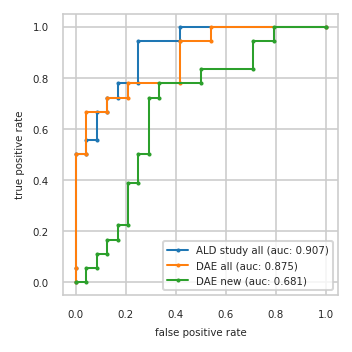

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.500   0.000 0.500   0.042 0.056
3          0.042 0.500   0.042 0.500   0.083 0.056
4          0.042 0.556   0.042 0.667   0.083 0.111
5          0.083 0.556   0.125 0.667   0.125 0.111
6          0.083 0.667   0.125 0.722   0.125 0.167
7          0.125 0.667   0.208 0.722   0.167 0.167
8          0.125 0.722   0.208 0.778   0.167 0.222
9          0.167 0.722   0.417 0.778   0.208 0.222
10         0.167 0.778   0.417 0.944   0.208 0.389
11         0.250 0.778   0.542 0.944   0.250 0.389
12         0.250 0.944   0.542 1.000   0.250 0.500
13         0.417 0.944   1.000 1.000   0.292 0.500
14         0.417 1.000     NaN   NaN   0.292 0.722
15         1.000 1.000     NaN   NaN   0.333 0.722
16           NaN   NaN     NaN   NaN   0.333 0.778
17           NaN   NaN     NaN   NaN   0.500 0.778
18           NaN   NaN     NaN   NaN   0.500 0.833
19           NaN   NaN     NaN   NaN   0.708 0.833
20           NaN   NaN     NaN   NaN   0.708 0.944
21           NaN   NaN     NaN   NaN   0.792 0.944
22           NaN   NaN     NaN   NaN   0.792 1.000
23           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P01701,Q9NX62,E5RK69;E7EMC6;P08133;P08133-2
2,P04114,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,P42262;P42262-2;P42262-3
3,Q8NCL4,P14174,P31150
4,P61981,Q14894,P31321
5,P09960;P09960-4,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,Q9Y2T3;Q9Y2T3-3,Q9Y2T3;Q9Y2T3-3,Q9NUQ9
7,P04075,P63104,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
8,P14174,P04075,O95497


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


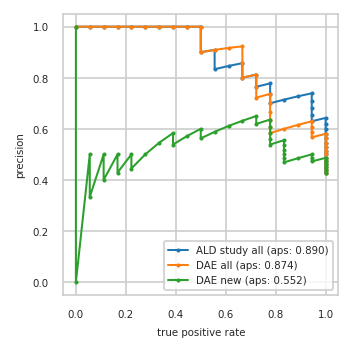

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.680 0.944     0.600 0.833     0.560 0.778
18         0.708 0.944     0.583 0.778     0.583 0.778
19         0.739 0.944     0.609 0.778     0.609 0.778
20         0.727 0.889     0.636 0.778     0.636 0.778
21         0.714 0.833     0.667 0.778     0.619 0.722
22         0.700 0.778     0.700 0.778     0.650 0.722
23         0.737 0.778     0.737 0.778     0.632 0.667
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.765 0.722     0.765 0.722     0.588 0.556
26         0.812 0.722     0.812 0.722     0.562 0.500
27         0.800 0.667     0.800 0.667     0.600 0.500
28         0.857 0.667     0.857 0.667     0.571 0.444
29         0.846 0.611     0.923 0.667     0.538 0.389
30         0.833 0.556     0.917 0.611     0.583 0.389
31         0.909 0.556     0.909 0.556     0.545 0.333
32         0.900 0.500     0.900 0.500     0.500 0.278
33         1.000 0.500     1.000 0.500     0.444 0.222
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


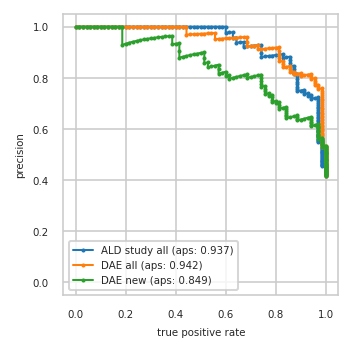

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


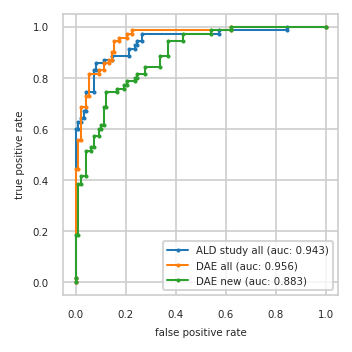

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}